# Keras tutorial - the Happy House

Welcome to this Keras tutorial. Here we will:
1. Learn to use Keras, a high-level neural networks API (programming framework), written in Python and capable of running on top of several lower-level frameworks including TensorFlow and CNTK. 
2. See how we can in a couple of hours build a deep learning algorithm.

Why are we using Keras? Keras was developed to enable deep learning engineers to build and experiment with different models very quickly. Just as TensorFlow is a higher-level framework than Python, Keras is an even higher-level framework and provides additional abstractions. Being able to go from idea to result with the least possible delay is key to finding good models. However, Keras is more restrictive than the lower-level frameworks, so there are some very complex models that you can implement in TensorFlow but not (without more difficulty) in Keras. That being said, Keras will work fine for many common models. 

In this exercise, we'll work on the "Happy House" problem explained below. Let's load the required packages and solve the problem of the Happy House!

In [13]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot, h5py
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

## 1 - The Happy House 

For your next vacation, you decided to spend a week with five of your friends from school. It is a very convenient house with many things to do nearby. But the most important benefit is that everybody has commited to be happy when they are in the house. So anyone wanting to enter the house must prove their current state of happiness.

<img src="images/happy-house.jpg" style="width:350px;height:270px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **the Happy House**</center></caption>


As a deep learning expert, to make sure the "Happy" rule is strictly applied, you are going to build an algorithm which that uses pictures from the front door camera to check if the person is happy or not. The door should open only if the person is happy. 

You have gathered pictures of your friends and yourself, taken by the front-door camera. The dataset is labbeled. 

<img src="images/house-members.png" style="width:550px;height:250px;">

Run the following code to normalize the dataset and learn about its shapes.

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


**Details of the "Happy" dataset**:
- Images are of shape (64,64,3)
- Training: 600 pictures
- Test: 150 pictures

It is now time to solve the "Happy" Challenge.

## 2 - Building a model in Keras

Keras is very good for rapid prototyping. In just a short time we are be able to build a model that achieves outstanding results. 

Note that Keras uses a different convention with variable names than we've previously used with numpy and TensorFlow. In particular, rather than creating and assigning a new variable on each step of forward propagation such as `X`, `Z1`, `A1`, `Z2`, `A2`, etc. for the computations for the different layers, in Keras code each line above just reassigns `X` to a new value using `X = ...`. In other words, during each step of forward propagation, we are just writing the latest value in the commputation into the same variable `X`. The only exception was `X_input`, which we kept separate and did not overwrite, since we needed it at the end to create the Keras model instance (`model = Model(inputs = X_input, ...)` above). 


In [3]:
def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(input_shape)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')    
    
    return model

We have now built a function to describe your model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).

In [11]:
happyModel = HappyModel((64, 64, 3))

In [12]:
#loss = "binary_crossentropy": It's a binary classification mproblem
happyModel.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [6]:
happyModel.fit(x = X_train, y = Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
600/600 [==============================] - 7s 11ms/step - loss: 1.3071 - acc: 0.6817
Epoch 2/20
600/600 [==============================] - 3s 6ms/step - loss: 0.2457 - acc: 0.8950
Epoch 3/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1438 - acc: 0.9517
Epoch 4/20
600/600 [==============================] - 3s 6ms/step - loss: 0.1169 - acc: 0.9700
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1106 - acc: 0.9517
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0763 - acc: 0.9817
Epoch 7/20
600/600 [==============================] - 3s 6ms/step - loss: 0.0796 - acc: 0.9817
Epoch 8/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0557 - acc: 0.9883
Epoch 9/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0654 - acc: 0.9783
Epoch 10/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0486 - acc: 0.9850
Epoch 11/20
600/600 [===========================

Note that if you run `fit()` again, the `model` will continue to train with the parameters it has already learnt instead of reinitializing them.

In [7]:
preds = happyModel.evaluate(x = X_test, y = Y_test)

print()
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 5ms/step

Loss = 0.1504107506076495
Test Accuracy = 0.920000003973643


If the `happyModel()` function worked, you should have observed much better than random-guessing (50%) accuracy on the train and test sets.

Note that the model gets decent accuracy after just 2-5 epochs, so if comparing different models we can also train a variety of models on just a few epochs and see how they compare. 

## 3 -  Useful functions in Keras

Two useful basic features of Keras are:
- `model.summary()`: prints the details of your layers in a table with the sizes of its inputs/outputs
- `plot_model()`: plots your graph in a nice layout. You can even save it as ".png" using SVG() if you'd like to share it on social media ;). It is saved in "File" then "Open..." in the upper bar of the notebook.

Run the following code.

In [8]:
happyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

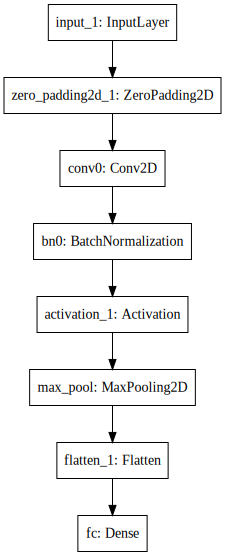

In [10]:
plot_model(happyModel, to_file='HappyModel.png')
SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))